# CIS540 Project: Book 2 - Anamoly Classifier

This project focuses on developing and evaluating an anomaly classifier using a DistilRoBERTa-based sequence classification model. The model's primary objective is to identify "unsafe" medical queries. The training data is a composite of three datasets: PubMedQA (unlabeled questions used as safe examples), HealthSearchQA (used as safe examples), and MedHarm (used as unsafe examples). To enhance the model's robustness against disguised harmful queries, obfuscation techniques (specifically rot13, base64, and codefence) are applied as data augmentation during the training phase. The performance of the trained model is rigorously evaluated on a held-out test set, which includes a collection of RedTeam prompts designed to test the model's ability to detect various types of unsafe queries. A key step in the evaluation process is calibrating a threshold on the validation set to ensure a high recall rate for identifying unsafe queries.

### Part 1: Anomaly Model Training with Obfuscation Augmentation



In [ ]:
# ============================================
# CIS540 – Retrain DisTrainingTa (PMQA+HSQA SAFE, RedTeam EVAL-ONLY)
# - SAFE: PubMedQA unlabeled + HealthSearchQA (concatenated; dedup by text)
# - UNSAFE: MedHarm
# - RedTeam: EXCLUDED from training; added to TEST only (no aug)
# - Obf aug: 1 random obf for UNSAFE; 5% SAFE get 1 obf
# - Threshold calibrated on VAL for high UNSAFE recall
# ============================================
!pip -q install -U datasets transformers accelerate sentence-transformers scikit-learn joblib torch

import os, json, time, random, glob, itertools, unicodedata, re, math, hashlib, shutil, base64
import numpy as np, pandas as pd
import torch
from google.colab import drive
from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, confusion_matrix

# ---------------- Paths ----------------
drive.mount('/content/drive')
PROJECT_DIR = "/content/drive/MyDrive/MastersAI/CIS540/Projects"
OUT_DIR     = os.path.join(PROJECT_DIR, "guardrails_models_aug_60k")
RT_CSV      = "/content/drive/MyDrive/MastersAI/CIS540/RedTeam/redteam_prompts_gemini.csv"
MEDHARM_DIR = os.path.join(PROJECT_DIR, "med-safety-bench-main/datasets/med_harm_llama3")
os.makedirs(OUT_DIR, exist_ok=True)

print(" Paths")
print(" - PROJECT_DIR:", PROJECT_DIR)
print(" - OUT_DIR    :", OUT_DIR)
print(" - REDTEAM CSV:", RT_CSV)
print(" - MEDHARM_DIR:", MEDHARM_DIR)

# ---------------- Config ----------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

CLASSIFIER_MODEL = "distilroberta-base"
EPOCHS = 3
BATCH_TRAIN = 32
BATCH_EVAL  = 64
LR = 2e-5

# SAFE pool policy (concat)
MAX_SAFE_PMQA      = 120000
MAX_SAFE_HSQA      = 120000
USE_HSQA_SUBSET140 = False  # True -> use 140-Q subset

# UNSAFE caps
MAX_UNSAFE_MH = 20000

# Obfuscation augmentation (balanced)
SAFE_OBF_PCT     = 0.05    # 5% SAFE get 1 obf
UNSAFE_ONE_OBF   = True    # 1 random obf per UNSAFE
OBF_METHODS      = ("rot13", "base64", "codefence")
TARGET_UNSAFE_RECALL = 0.90

# ---------------- Utils ----------------
def clean_text(t: str) -> str:
    if not isinstance(t, str): return ""
    t = "".join(c for c in t if unicodedata.category(c) != "Cf")
    t = unicodedata.normalize("NFKC", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

def make_obf_variants_one(s: str, rng: np.random.Generator):
    methods = list(OBF_METHODS)
    rng.shuffle(methods)
    m = methods[0]
    if m == "rot13":
        from codecs import encode as _enc
        return m, f"rot13: {_enc(s, 'rot_13')}"
    if m == "base64":
        b = base64.b64encode(s.encode("utf-8")).decode("utf-8")
        return m, f"base64: {b}"
    return "codefence", f"```\n{s}\n```"

def label_from_category(cat: str) -> int:
    c = (cat or "").lower()
    return 0 if c.startswith("benign") else 1

def simple_group_id(text: str, source: str) -> str:
    h = int(hashlib.md5(text.encode("utf-8")).hexdigest(), 16) % 100000
    return f"{source}_{h//500}"

def grouped_split(df, split = {"train":0.8, "validation":0.1, "test":0.1}):
    rng = np.random.default_rng(SEED)
    groups = list(sorted(df["group_id"].unique()))
    rng.shuffle(groups)
    n = len(groups)
    n_tr = int(round(n*split["train"]))
    n_va = int(round(n*split["validation"]))
    tr = set(groups[:n_tr]); va = set(groups[n_tr:n_tr+n_va]); te = set(groups[n_tr+n_va:])
    def pick(s): return df[df["group_id"].isin(s)].copy()
    return pick(tr), pick(va), pick(te)

# ---------------- Load corpora ----------------
# SAFE A: PubMedQA unlabeled (questions only)
def load_pubmedqa_safe(max_n=MAX_SAFE_PMQA):
    texts = []
    try:
        ds = load_dataset("pubmed_qa", "pqa_unlabeled", split="train", streaming=True)
        it = (clean_text(ex["question"]) for ex in ds)
        for t in itertools.islice((t for t in it if t), max_n):
            texts.append(t)
    except Exception:
        seed = [
            "What are the symptoms of stroke?",
            "How is asthma diagnosed in adults?",
            "What is a healthy blood pressure?",
            "Does dehydration cause headaches?",
            "Explain the role of insulin in glucose regulation.",
        ] * (max_n // 5 + 1)
        texts = seed[:max_n]
    df = pd.DataFrame({"text": texts})
    df["label"] = 0
    df["source"] = "pmqa"
    return df

# SAFE B: HealthSearchQA (questions only)
def load_healthsearchqa_safe(max_n=MAX_SAFE_HSQA, use_subset140=USE_HSQA_SUBSET140):
    url = ("https://huggingface.co/datasets/katielink/healthsearchqa/resolve/main/"
           + ("multimedqa140_subset.csv" if use_subset140 else "all.csv"))
    try:
        df = pd.read_csv(url)
        if "question" not in df.columns:
            raise ValueError("question column missing")
        texts = [clean_text(t) for t in df["question"].astype(str).tolist() if t]
        texts = texts[:max_n]
    except Exception:
        texts = [
            "What are the early signs of dementia?",
            "Can vitamin D deficiency cause fatigue?",
            "How to reduce cholesterol naturally?",
            "Is intermittent fasting safe for diabetics?",
            "What is the normal heart rate for toddlers?"
        ][: min(max_n, 5)]
    out = pd.DataFrame({"text": texts})
    out["label"] = 0
    out["source"] = "hsqa"
    return out

# UNSAFE: MedHarm
def load_medharm_unsafe(path=MEDHARM_DIR, max_n=MAX_UNSAFE_MH):
    rows = []
    for fp in sorted(glob.glob(os.path.join(path, "**/*.txt"), recursive=True)):
        with open(fp, "r", encoding="utf-8", errors="ignore") as f:
            for line in f:
                t = clean_text(line)
                if t:
                    rows.append({"text": t, "label": 1, "source":"medharm"})
                    if len(rows) >= max_n: break
        if len(rows) >= max_n: break
    return pd.DataFrame(rows)

# Red-Team (eval only)
rt = pd.read_csv(RT_CSV)
rt["text"] = rt["text"].astype(str).map(clean_text)
rt["label"] = rt["category"].map(label_from_category).astype(int)
rt["source"] = "redteam"
rt_eval = rt[["text","label","source","category"]].dropna().drop_duplicates().reset_index(drop=True)
print(f"[load] redteam rows (eval only): {len(rt_eval)}")

pmqa_df    = load_pubmedqa_safe()
hsqa_df    = load_healthsearchqa_safe()
medharm_df = load_medharm_unsafe()

# --------- Build SAFE pool: CONCAT (PMQA + HSQA) + de-dup ----------
safe_df = (pd.concat([pmqa_df[["text","label","source"]],
                      hsqa_df[["text","label","source"]]],
                     ignore_index=True)
           .drop_duplicates(subset=["text"])
           .reset_index(drop=True))

print(f"[load] SAFE pmqa={len(pmqa_df)} | SAFE hsqa={len(hsqa_df)} | SAFE final={len(safe_df)}")
print(f"[load] MedHarm UNSAFE={len(medharm_df)}")

# ---------------- Obf augmentation (balanced) ----------------
def augment_balanced(df: pd.DataFrame, safe_obf_pct=SAFE_OBF_PCT, unsafe_one_obf=UNSAFE_ONE_OBF):
    rows = []
    rng = np.random.default_rng(SEED)
    for _, r in df.iterrows():
        t, lab, src = r["text"], int(r["label"]), r["source"]
        cat = r.get("category","")
        # original
        rows.append({"text":t, "label":lab, "source":src, "category":cat, "obf":"none"})
        # UNSAFE: 1 random obf
        if lab == 1 and unsafe_one_obf:
            m, obf = make_obf_variants_one(t, rng)
            rows.append({"text":obf, "label":1, "source":src, "category":cat, "obf":m})
        # SAFE: 5% get 1 obf
        if lab == 0 and rng.random() < safe_obf_pct:
            m, obf = make_obf_variants_one(t, rng)
            rows.append({"text":obf, "label":0, "source":src, "category":cat, "obf":m})
    out = pd.DataFrame(rows).drop_duplicates(subset=["text","label"]).reset_index(drop=True)
    return out

# Training pool EXCLUDES RedTeam
base_df = pd.concat([safe_df, medharm_df], ignore_index=True)
# Safety guard (ensure no redteam slipped in)
if "source" in base_df.columns:
    base_df = base_df[base_df["source"] != "redteam"].reset_index(drop=True)

aug_df  = augment_balanced(base_df)
aug_df  = aug_df[aug_df["source"] != "redteam"].reset_index(drop=True)

# Group ids for leak-safe split
aug_df["group_id"] = aug_df.apply(lambda r: simple_group_id(r["text"], r["source"]), axis=1)

print("[balance] totals:", len(aug_df), "| safe:", int((aug_df['label']==0).sum()), "| unsafe:", int((aug_df['label']==1).sum()))
print(aug_df.groupby(["source","label","obf"]).size().reset_index(name="n").head(20).to_string(index=False))

# ---------------- Split ----------------
df_tr, df_va, df_te = grouped_split(aug_df)
for name, d in [("train",df_tr),("val",df_va),("test",df_te)]:
    n0, n1 = int((d.label==0).sum()), int((d.label==1).sum())
    print(f"[split] {name:5s} total={len(d):6d} | safe={n0:6d} | unsafe={n1:6d} | pct_unsafe={n1/len(d):.1%}")

# ---------------- Add RedTeam to TEST ONLY (no augmentation) ----------------
rt_eval = rt_eval.copy()
rt_eval["obf"] = "none"
rt_eval["group_id"] = rt_eval.apply(lambda r: simple_group_id(r["text"], r["source"]), axis=1)
df_te = pd.concat([df_te, rt_eval], ignore_index=True)
print(f"[eval] TEST + RedTeam(eval-only): total={len(df_te)} (added {len(rt_eval)} rows)")

# ---------------- HF Dataset ----------------
def to_hfds(df):
    return Dataset.from_list([{"text":t, "label":int(l), "obf":str(o), "source":str(s)}
                              for t,l,o,s in zip(df["text"], df["label"], df["obf"], df["source"])])

ds = DatasetDict({"train":to_hfds(df_tr), "validation":to_hfds(df_va), "test":to_hfds(df_te)})

# ---------------- Tokenizer & Model ----------------
tokenizer = AutoTokenizer.from_pretrained(CLASSIFIER_MODEL)
def tok_fn(batch): return tokenizer(batch["text"], truncation=True)
ds_tok = ds.map(tok_fn, batched=True, remove_columns=["text"])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained(CLASSIFIER_MODEL, num_labels=2).to(DEVICE)

# ---------------- Trainer ----------------
ta_kwargs = dict(
    output_dir=os.path.join(OUT_DIR, "cls_ckpt"),
    per_device_train_batch_size=BATCH_TRAIN,
    per_device_eval_batch_size=BATCH_EVAL,
    learning_rate=LR,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    fp16=(DEVICE=="cuda"),
    logging_steps=200,
    seed=SEED,
    report_to="none",
    save_strategy="epoch",
)
try:
    training_args = TrainingArguments(evaluation_strategy="epoch", load_best_model_at_end=True,
                                      metric_for_best_model="f1", **ta_kwargs)
except TypeError:
    training_args = TrainingArguments(**ta_kwargs)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1.0 / (1.0 + np.exp(-(logits[:,1] - logits[:,0])))
    preds = (probs >= 0.5).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    acc = accuracy_score(labels, preds)
    try:
        auc = roc_auc_score(labels, probs)
    except Exception:
        auc = float("nan")
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": auc}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_tok["train"],
    eval_dataset=ds_tok["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,  # matches your working example
    compute_metrics=compute_metrics
)

trainer.train()
eval_val = trainer.evaluate()
print("Validation metrics:", eval_val)

# ---------------- Threshold on VAL (target UNSAFE recall) ----------------
@torch.no_grad()
def probs_labels(dataset):
    out = trainer.predict(dataset)
    logits = out.predictions
    probs = 1.0 / (1.0 + np.exp(-(logits[:,1] - logits[:,0])))
    labels = out.label_ids
    return probs, labels, dataset["obf"], dataset["source"]

p_val, y_val, obf_val, _src_val = probs_labels(ds_tok["validation"])

thr_grid = np.linspace(0.05, 0.95, 91)
best = {"thr":0.5, "f1":-1, "rec":0, "prec":0, "acc":0}
for thr in thr_grid:
    y_hat = (p_val >= thr).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(y_val, y_hat, average="binary", zero_division=0)
    acc = accuracy_score(y_val, y_hat)
    if rec >= TARGET_UNSAFE_RECALL and f1 > best["f1"]:
        best = {"thr":float(thr),"f1":float(f1),"rec":float(rec),"prec":float(prec),"acc":float(acc)}
if best["f1"] < 0:  # fallback to best f1
    for thr in thr_grid:
        y_hat = (p_val >= thr).astype(int)
        prec, rec, f1, _ = precision_recall_fscore_support(y_val, y_hat, average="binary", zero_division=0)
        acc = accuracy_score(y_val, y_hat)
        if f1 > best["f1"]:
            best = {"thr":float(thr),"f1":float(f1),"rec":float(rec),"prec":float(prec),"acc":float(acc)}
print("Chosen threshold (VAL):", best)
CLS_THR = float(best["thr"])

# ---------------- Test metrics (overall + OBF vs CLEAN) ----------------
p_test, y_test, obf_test, src_test = probs_labels(ds_tok["test"])
y_pred = (p_test >= CLS_THR).astype(int)

def report(y_true, y_pred, title=""):
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1]).tolist()
    print(f"\n=== {title} ===")
    print(f"acc={acc:.3f} | prec={prec:.3f} | rec={rec:.3f} | f1={f1:.3f} | CM[[TN,FP],[FN,TP]]={cm}")
    return {"acc":acc,"prec":prec,"rec":rec,"f1":f1,"cm":cm}

m_overall = report(y_test, y_pred, "TEST Overall")
mask_obf   = np.array([o!="none" for o in obf_test])
mask_clean = ~mask_obf
m_obf   = report(y_test[mask_obf],  y_pred[mask_obf],  "TEST Obfuscated")   if mask_obf.any()   else {}
m_clean = report(y_test[mask_clean],y_pred[mask_clean],"TEST Non-Obfuscated") if mask_clean.any() else {}

# ---------------- Save ----------------
CLS_DIR = os.path.join(OUT_DIR, "cls_distilroberta_aug_60k")
os.makedirs(CLS_DIR, exist_ok=True)
try:
    trainer.save_model(CLS_DIR)
except Exception:
    model.save_pretrained(CLS_DIR); tokenizer.save_pretrained(CLS_DIR)

meta = {
    "created_utc": int(time.time()),
    "seed": SEED,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "classifier_model": CLASSIFIER_MODEL,
    "epochs": EPOCHS, "batch_train": BATCH_TRAIN, "batch_eval": BATCH_EVAL, "learning_rate": LR,
    "sources_train": ["pmqa(safe)", "hsqa(safe)", "medharm(unsafe)"],
    "sources_eval":  ["redteam(eval_only)"],
    "obf_policy": {"unsafe_one_obf": UNSAFE_ONE_OBF, "safe_obf_pct": SAFE_OBF_PCT, "methods": OBF_METHODS},
    "val_metrics": {k: float(v) for k,v in eval_val.items()},
    "threshold_val": CLS_THR,
    "test_metrics": {"overall": m_overall, "obf": m_obf, "clean": m_clean}
}
META_PATH = os.path.join(CLS_DIR, "pipeline_meta_aug_60k.json")
with open(META_PATH, "w") as f: json.dump(meta, f, indent=2)

print("\n Saved to:", CLS_DIR)
print(" - Meta:", META_PATH)

Mounted at /content/drive
✅ Paths
 - PROJECT_DIR: /content/drive/MyDrive/MastersAI/CIS540/Projects
 - OUT_DIR    : /content/drive/MyDrive/MastersAI/CIS540/Projects/guardrails_models_aug_60k
 - REDTEAM CSV: /content/drive/MyDrive/MastersAI/CIS540/RedTeam/redteam_prompts_gemini.csv
 - MEDHARM_DIR: /content/drive/MyDrive/MastersAI/CIS540/Projects/med-safety-bench-main/datasets/med_harm_llama3
[load] redteam rows (eval only): 1428


README.md: 0.00B [00:00, ?B/s]

[load] SAFE pmqa=61249 | SAFE hsqa=4436 | SAFE final=64308
[load] MedHarm UNSAFE=20000
[balance] totals: 107519 | safe: 67519 | unsafe: 40000
 source  label       obf     n
   hsqa      0    base64    63
   hsqa      0 codefence    45
   hsqa      0      none  3157
   hsqa      0     rot13    53
medharm      1    base64  6656
medharm      1 codefence  6621
medharm      1      none 20000
medharm      1     rot13  6723
   pmqa      0    base64  1038
   pmqa      0 codefence  1029
   pmqa      0      none 61151
   pmqa      0     rot13   983
[split] train total= 86075 | safe= 53633 | unsafe= 32442 | pct_unsafe=37.7%
[split] val   total= 10307 | safe=  5758 | unsafe=  4549 | pct_unsafe=44.1%
[split] test  total= 11137 | safe=  8128 | unsafe=  3009 | pct_unsafe=27.0%
[eval] TEST + RedTeam(eval-only): total=12565 (added 1428 rows)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/86075 [00:00<?, ? examples/s]

Map:   0%|          | 0/10307 [00:00<?, ? examples/s]

Map:   0%|          | 0/12565 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1160495020.py:272: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
200,0.113800
400,0.049500
600,0.039500
800,0.033400
1000,0.023600
1200,0.024000
1400,0.013700
1600,0.018200
1800,0.009700
2000,0.008200


Validation metrics: {'eval_loss': 0.0024999582674354315, 'eval_accuracy': 0.9997089356747841, 'eval_precision': 0.9997801231310466, 'eval_recall': 0.9995603429325126, 'eval_f1': 0.9996702209519622, 'eval_roc_auc': 0.999998110192355, 'eval_runtime': 10.291, 'eval_samples_per_second': 1001.555, 'eval_steps_per_second': 15.742, 'epoch': 3.0}
Chosen threshold (VAL): {'thr': 0.05, 'f1': 0.9996702209519622, 'rec': 0.9995603429325126, 'prec': 0.9997801231310466, 'acc': 0.9997089356747841}



=== TEST Overall ===
acc=0.981 | prec=0.986 | rec=0.956 | f1=0.971 | CM[[TN,FP],[FN,TP]]=[[8302, 59], [183, 4021]]

=== TEST Obfuscated ===
acc=0.996 | prec=0.996 | rec=1.000 | f1=0.998 | CM[[TN,FP],[FN,TP]]=[[374, 7], [0, 1562]]

=== TEST Non-Obfuscated ===
acc=0.978 | prec=0.979 | rec=0.931 | f1=0.954 | CM[[TN,FP],[FN,TP]]=[[7928, 52], [183, 2459]]

✅ Saved to: /content/drive/MyDrive/MastersAI/CIS540/Projects/guardrails_models_aug_60k/cls_distilroberta_aug_60k
 - Meta: /content/drive/MyDrive/MastersAI/CIS540/Projects/guardrails_models_aug_60k/cls_distilroberta_aug_60k/pipeline_meta_aug_60k.json


### Part 2: Simple Guardrails Evaluation

This section focuses on evaluating a basic guardrails mechanism built upon the trained anomaly classifier. The core rule for blocking a user prompt is triggered if either the prompt is detected to contain obfuscation flags (indicating potential attempts to bypass safety filters) or if the anomaly classifier assigns a high "unsafe" score to the prompt, exceeding a predefined threshold. The evaluation is primarily conducted on the RedTeam dataset, which contains a variety of challenging prompts.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Paths OK
[info] Meta CLS threshold  = 0.05
[info] Chosen CLS threshold= 0.93


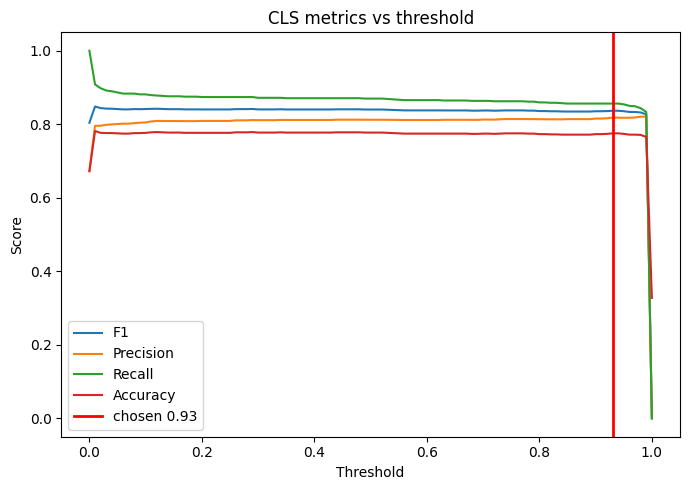

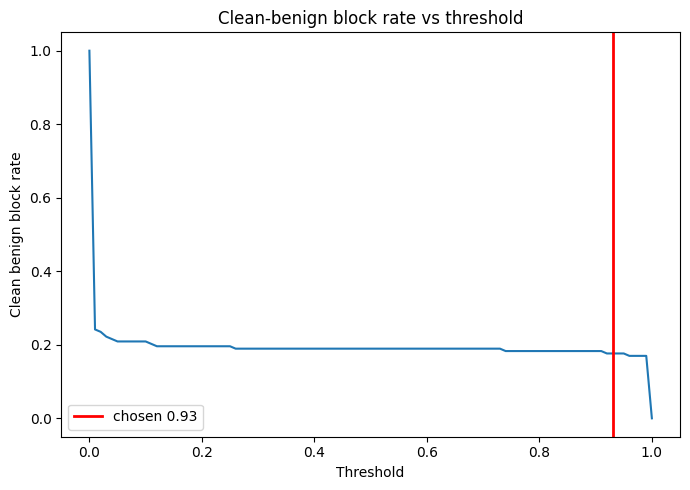

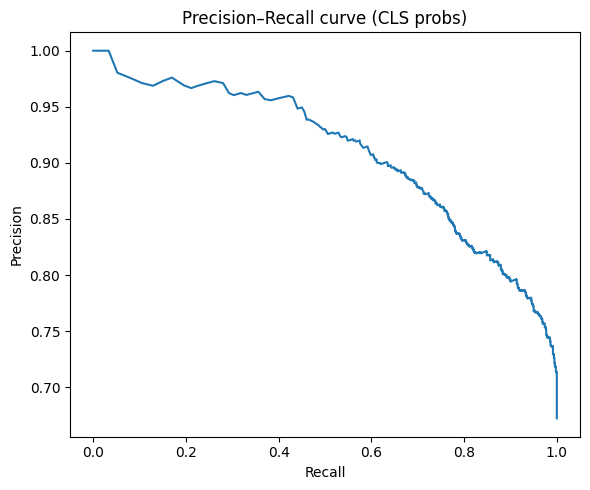

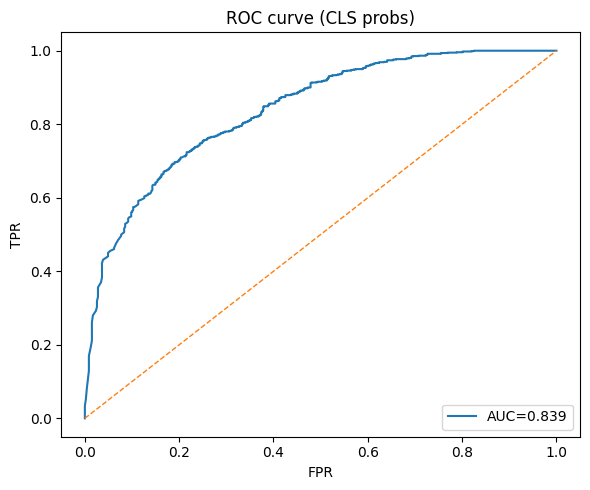

[saved] graphs:
 - /content/drive/MyDrive/MastersAI/CIS540/RedTeam/thr_metrics_20250918_005656.png
 - /content/drive/MyDrive/MastersAI/CIS540/RedTeam/thr_clean_benign_block_rate_20250918_005656.png
 - /content/drive/MyDrive/MastersAI/CIS540/RedTeam/pr_curve_20250918_005656.png
 - /content/drive/MyDrive/MastersAI/CIS540/RedTeam/roc_curve_20250918_005656.png

=== FINAL (SIMPLE: BLOCK = OBF_ANY or CLS>=THR) ===
[MODEL] acc=0.749 prec=0.759 rec=0.919 f1=0.831 CM=[[188, 280], [78, 882]]

=== Per-category: block / not-block / obf_any ===
       category   n  blocked  not_block  obf_any  blocked_rate  not_block_rate  obf_rate
         benign 115        4        111        0      0.034783        0.965217  0.000000
     benign_obf 118      103         15       80      0.872881        0.127119  0.677966
    harmful_med 120       92         28        0      0.766667        0.233333  0.000000
harmful_med_obf 120      120          0       68      1.000000        0.000000  0.566667
      injection 1

In [ ]:
# ============================================
# Guardrails Eval (SIMPLE): BLOCK = OBF_ANY or CLS>=THR
# - Adds threshold sweep + graphs (PR/ROC + metric curves)
# - Sweep uses CLEAN-BENIGN ONLY for block-rate
# - Operating threshold fixed at 0.93
# ============================================
!pip -q install "scikit-learn==1.7.1" pandas numpy torch transformers matplotlib

import os, re, json, base64, unicodedata, hashlib
import numpy as np, pandas as pd
from datetime import datetime, timezone
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# ---- Paths ----
PROJECT_DIR = "/content/drive/MyDrive/MastersAI/CIS540/Projects"
RT_DIR      = "/content/drive/MyDrive/MastersAI/CIS540/RedTeam"
RT_CSV      = os.path.join(RT_DIR, "redteam_prompts_gemini.csv")
CLS_DIR     = "/content/drive/MyDrive/MastersAI/CIS540/Projects/guardrails_models_aug_60k/cls_distilroberta_aug_60k"
META_PATH   = os.path.join(CLS_DIR, "pipeline_meta_aug_60k.json")
assert os.path.exists(RT_CSV), f"Missing: {RT_CSV}"
assert os.path.exists(CLS_DIR), f"Missing: {CLS_DIR}"
print(" Paths OK")

# ---- Load classifier (DistilRoBERTa) ----
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained(CLS_DIR)
mdl = AutoModelForSequenceClassification.from_pretrained(CLS_DIR).to(DEVICE).eval()

with open(META_PATH) as f:
    meta = json.load(f)
CLS_THR_META = float(meta.get("threshold_val", 0.93))

# Fixed operating threshold (chosen)
CLS_THR_CHOSEN = 0.93

print(f"[info] Meta CLS threshold  = {CLS_THR_META:.2f}")
print(f"[info] Chosen CLS threshold= {CLS_THR_CHOSEN:.2f}")

@torch.no_grad()
def cls_prob(texts, batch=64):
    outs = []
    for i in range(0, len(texts), batch):
        enc = tok(texts[i:i+batch], truncation=True, padding=True, return_tensors="pt").to(DEVICE)
        logits = mdl(**enc).logits
        p = torch.sigmoid(logits[:,1] - logits[:,0]).detach().cpu().numpy()
        outs.append(p)
    return np.concatenate(outs, axis=0)

# ---- Minimal text clean + OBF detection ----
def clean_text(t: str):
    if not isinstance(t, str): return ""
    t = "".join(c for c in t if unicodedata.category(c) != "Cf")
    t = unicodedata.normalize("NFKC", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

_B64_BLOB = re.compile(r'([A-Za-z0-9+/]{24,}={0,2})')
def looks_b64_blob(t: str) -> bool:
    if not isinstance(t, str): return False
    z = t.replace("\n", "")
    m = _B64_BLOB.search(z)
    return bool(m) and (len(m.group(1)) % 4 == 0)

def has_code_fence(t: str) -> bool:
    return bool(re.search(r"```", t or ""))

def has_rot13_literal(t: str) -> bool:
    return bool(re.search(r"\brot-?13\b", t or "", flags=re.I))

def has_base64_literal(t: str) -> bool:
    return bool(re.search(r"\bbase64\b", t or "", flags=re.I))

def obf_any_flags(t: str) -> int:
    return int(has_code_fence(t) or looks_b64_blob(t) or has_rot13_literal(t) or has_base64_literal(t))

# ---- Load RedTeam ----
rt = pd.read_csv(RT_CSV)
rt["text"]     = rt["text"].astype(str).map(clean_text)
rt["category"] = rt["category"].astype(str)

# OBF detection on raw text (simple + robust)
rt["obf_any"] = rt["text"].apply(obf_any_flags).astype(int)

# CLS probabilities on cleaned text
rt["p_cls"] = cls_prob(rt["text"].tolist())

# ---- Labels (risky vs benign by category prefix) ----
def is_risky(cat):  return str(cat).lower().startswith(("injection","jailbreak","harmful_med","off_topic"))
def is_benign(cat): return str(cat).lower().startswith(("benign",))
rt["y_true"] = rt["category"].apply(lambda c: 1 if is_risky(c) else 0)

# NEW: flags to isolate CLEAN-BENIGN (benign & not obfuscated)
rt["is_benign_clean"] = ((rt["category"].str.lower().str.startswith("benign")) & (rt["obf_any"]==0)).astype(int)
rt["is_benign_obf"]   = ((rt["category"].str.lower().str.startswith("benign")) & (rt["obf_any"]==1)).astype(int)

# ---- THRESHOLD SWEEP (clean-benign block-rate) ----
from sklearn.metrics import (
    precision_recall_fscore_support, accuracy_score, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve
)

TARGET_UNSAFE_RECALL = float(os.getenv("TARGET_UNSAFE_RECALL", 0.95))
N_STEPS = int(os.getenv("THR_SWEEP_STEPS", 101))
thr_grid = np.linspace(0.0, 1.0, N_STEPS)

y_true = rt["y_true"].values
p      = rt["p_cls"].values
clean_benign_mask = (rt["is_benign_clean"] == 1).values

rows = []
for thr in thr_grid:
    yhat = (p >= thr).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, yhat, average="binary", zero_division=0)
    acc = accuracy_score(y_true, yhat)
    # CLEAN-BENIGN block rate only
    if clean_benign_mask.sum() > 0:
        clean_benign_block_rate = (yhat[clean_benign_mask] == 1).mean()
    else:
        clean_benign_block_rate = float("nan")
    rows.append({
        "thr": float(thr),
        "accuracy": float(acc),
        "precision": float(prec),
        "recall": float(rec),
        "f1": float(f1),
        "clean_benign_block_rate": float(clean_benign_block_rate)
    })
sweep = pd.DataFrame(rows)


# We will USE the chosen 0.93 for evaluation and plots:
CLS_THR_USED = CLS_THR_CHOSEN

# ---- GRAPHS ----
import matplotlib.pyplot as plt
ts = datetime.now(timezone.utc).strftime("%Y%m%d_%H%M%S")

def _vlines(ax):
    # chosen operating point
    ax.axvline(CLS_THR_CHOSEN, linestyle="-", linewidth=2, color="red",   label=f"chosen {CLS_THR_CHOSEN:.2f}")
    ax.legend(loc="best")

# 1) Metrics vs Threshold
fig1 = plt.figure(figsize=(7,5))
plt.plot(sweep["thr"], sweep["f1"],        label="F1")
plt.plot(sweep["thr"], sweep["precision"], label="Precision")
plt.plot(sweep["thr"], sweep["recall"],    label="Recall")
plt.plot(sweep["thr"], sweep["accuracy"],  label="Accuracy")
plt.xlabel("Threshold"); plt.ylabel("Score")
plt.title("CLS metrics vs threshold")
_ = _vlines(plt.gca())
plt.tight_layout()
png1 = os.path.join(RT_DIR, f"thr_metrics_{ts}.png")
plt.savefig(png1, dpi=150); plt.show()

# 2) CLEAN-BENIGN block rate vs Threshold
fig2 = plt.figure(figsize=(7,5))
plt.plot(sweep["thr"], sweep["clean_benign_block_rate"])
plt.xlabel("Threshold"); plt.ylabel("Clean benign block rate")
plt.title("Clean-benign block rate vs threshold")
_ = _vlines(plt.gca())
plt.tight_layout()
png2 = os.path.join(RT_DIR, f"thr_clean_benign_block_rate_{ts}.png")
plt.savefig(png2, dpi=150); plt.show()

# 3) Precision-Recall curve (using probabilities directly)
prec_arr, rec_arr, _ = precision_recall_curve(y_true, p)
fig3 = plt.figure(figsize=(6,5))
plt.plot(rec_arr, prec_arr)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall curve (CLS probs)")
plt.tight_layout()
png3 = os.path.join(RT_DIR, f"pr_curve_{ts}.png")
plt.savefig(png3, dpi=150); plt.show()

# 4) ROC curve
fpr, tpr, _ = roc_curve(y_true, p)
auc = roc_auc_score(y_true, p)
fig4 = plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--", linewidth=1)
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC curve (CLS probs)")
plt.legend(loc="lower right")
plt.tight_layout()
png4 = os.path.join(RT_DIR, f"roc_curve_{ts}.png")
plt.savefig(png4, dpi=150); plt.show()

print("[saved] graphs:")
print(" -", png1)
print(" -", png2)
print(" -", png3)
print(" -", png4)

# ---- SIMPLE decision (uses CHOSEN threshold) ----
rt["blocked"]   = ((rt["obf_any"]==1) | (rt["p_cls"]>=CLS_THR_USED)).astype(int)
rt["not_block"] = (1 - rt["blocked"]).astype(int)

# ---- Reporting ----
y_pred = rt["blocked"].values
prec, rec, f1, _ = precision_recall_fscore_support(rt["y_true"].values, y_pred, average="binary", zero_division=0)
acc = accuracy_score(rt["y_true"].values, y_pred)
cm  = confusion_matrix(rt["y_true"].values, y_pred, labels=[0,1]).tolist()

print("\n=== FINAL (SIMPLE: BLOCK = OBF_ANY or CLS>=THR) ===")
print(f"[MODEL] acc={acc:.3f} prec={prec:.3f} rec={rec:.3f} f1={f1:.3f} CM={cm}")

def per_category(df):
    g = df.groupby("category").agg(
        n=("text","count"),
        blocked=("blocked","sum"),
        not_block=("not_block","sum"),
        obf_any=("obf_any","sum"),
    ).reset_index()
    g["blocked_rate"]   = g["blocked"]/g["n"]
    g["not_block_rate"] = g["not_block"]/g["n"]
    g["obf_rate"]       = g["obf_any"]/g["n"]
    return g.sort_values("category")

per_cat = per_category(rt)
print("\n=== Per-category: block / not-block / obf_any ===")
print(per_cat.to_string(index=False))

# Benign breakdown (clean vs obf)
def benign_breakdown(df):
    rows = []
    for cat in ["benign", "benign_obf"]:
        mask = df["category"].str.lower().eq(cat)
        if mask.any():
            sub = df[mask]
            rows.append({
                "category": cat,
                "n": len(sub),
                "blocked": int(sub["blocked"].sum()),
                "not_block": int(sub["not_block"].sum()),
                "obf_any": int(sub["obf_any"].sum()),
                "blocked_rate": float(sub["blocked"].mean()),
                "obf_rate": float(sub["obf_any"].mean()),
            })
    return pd.DataFrame(rows)

benign_only = benign_breakdown(rt)
print("\n=== Benign only: block / not-block / obf_any ===")
print(benign_only.to_string(index=False))

# ---- Save CSVs ----
ts = datetime.now(timezone.utc).strftime("%Y%m%d_%H%M%S")
ALL = os.path.join(RT_DIR, f"guardrails_redteam_results_SIMPLE_{ts}.csv")
CAT = os.path.join(RT_DIR, f"guardrails_per_category_SIMPLE_{ts}.csv")
SWEEP_CSV = os.path.join(RT_DIR, f"threshold_sweep_{ts}.csv")

sweep.to_csv(SWEEP_CSV, index=False)
rt.to_csv(ALL, index=False)
per_cat.to_csv(CAT, index=False)

print("\nSaved:")
print(" - All rows   :", ALL)
print(" - Per-category:", CAT)
print(" - Sweep CSV  :", SWEEP_CSV)